<a href="https://colab.research.google.com/github/djcordhose/mlops-drift/blob/main/notebooks/drift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting drift

* complete code in `src/insurance_prediction/monitoring/data_drift.py`
  * implemented as a decorator: https://docs.python.org/3/search.html?q=decorator
* you can let evidently choose the test or make your own choice
  * allows to select per type or per feature: https://docs.evidentlyai.com/reference/api-reference/evidently.options
  * which test: https://www.evidentlyai.com/blog/data-drift-detection-large-datasets
  

In [3]:
# for Colab
# !pip install -q evidently

In [5]:
from evidently.metrics import DatasetDriftMetric
from evidently.base_metric import InputData, ColumnMapping
from evidently.runner.loader import DataLoader, DataOptions
from evidently.calculations.data_drift import get_drift_for_columns
from evidently.options import DataDriftOptions
from evidently.utils.data_operations import process_columns


In [8]:
reference_dataset_url = 'https://github.com/DJCordhose/mlops-drift/raw/main/datasets/insurance_prediction/reference.csv.gz'
# reference_dataset_url = '../datasets/insurance_prediction/reference.csv.gz'

In [11]:
reference_dataset = DataLoader().load(
   filename=reference_dataset_url,
   data_options = DataOptions(date_column=None, separator=';'),
)
reference_dataset = reference_dataset.drop(['risk', 'group', 'group_name'], axis='columns')
reference_dataset

,training,age,emergency_braking,braking_distance,power,miles
0,0,41.951100,0,40.933328,122.238329,98.509765
1,0,24.368286,1,44.797317,113.765298,46.324178
2,0,18.314649,1,41.587241,143.427269,76.862968
3,0,51.265254,1,47.266716,111.578133,102.697069
4,0,23.578861,0,42.835319,145.994235,63.690055
...,...,...,...,...,...,...
1495,0,18.415981,0,43.287854,116.634741,75.460133
1496,0,58.728188,0,40.898519,183.982107,135.215255
1497,0,19.143734,0,28.608103,74.480472,65.951781
1498,0,42.633405,0,33.002569,118.829605,61.852056


In [ ]:

column_mapping = ColumnMapping(
    categorical_features=['training', 'emergency_braking'],
    numerical_features=['age', 'braking_distance', 'power', 'miles'],
    prediction=None,
    target=None,
)
columns = column_mapping.categorical_features + column_mapping.numerical_features

dataset_drift_metric = DatasetDriftMetric(columns=columns)
drift_share = 0.5


In [1]:
import tensorflow as tf
tf.__version__

2023-09-13 08:52:59.477988: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-13 08:52:59.711610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.12.0'

In [2]:
tf.random.set_seed(42)

In [3]:
import numpy as np
np.__version__

'1.23.5'

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 16

# Step 1: Loading and exploring our data set
## Compare plots to reference data and newer iteration 
* Compare results to exploration notebook http://localhost:8888/notebooks/notebooks/exploration.ipynb

In [5]:
# how many months after training?
iteration = 36

In [6]:
import pandas as pd

df = pd.read_csv(f'https://github.com/DJCordhose/mlops-drift/raw/main/datasets/insurance_prediction/monthly/month-{iteration}.csv.gz', delimiter=';')
# df = pd.read_csv(f'../data/month-{iteration}.csv', delimiter=';')

In [7]:
df.columns

Index(['training', 'age', 'emergency_braking', 'braking_distance', 'power',
       'miles', 'risk', 'group_name', 'group'],
      dtype='object')

In [8]:
df.head()

,training,age,emergency_braking,braking_distance,power,miles,risk,group_name,group
0,0,45.700860,1,33.730669,118.306787,92.429050,-0.813517,low,2
1,0,53.091268,1,35.575746,168.151487,53.595707,0.226851,low,2
2,1,41.989477,1,37.515860,104.683894,40.402020,-1.406092,low,2
3,0,41.792728,1,44.043184,143.531543,46.462029,0.667405,low,2
4,1,28.679302,1,34.329172,85.439495,39.791829,-1.693063,low,2


In [9]:
df.describe()

,training,age,emergency_braking,braking_distance,power,miles,risk,group
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.180667,39.438736,0.938667,40.051490,135.215854,62.765366,0.530821,1.622000
std,0.384870,13.261725,0.240021,5.072253,35.950635,25.582015,1.301681,0.539732
min,0.000000,19.786403,0.000000,22.509900,26.938595,5.000000,-3.828745,0.000000
25%,0.000000,28.474238,1.000000,36.687131,109.462877,43.222911,-0.381861,1.000000
50%,0.000000,36.935743,1.000000,40.342817,132.244743,58.121909,0.519117,2.000000
75%,0.000000,47.503926,1.000000,43.311050,155.987021,79.320875,1.392502,2.000000
max,1.000000,96.931120,1.000000,57.967082,284.698999,175.221602,5.530662,2.000000


# Observations

*  mean of age, miles, emergency_braking clearly shifted

In [10]:
import seaborn as sns
sns.__version__

'0.12.2'

In [11]:
labels = ["High Risk", "Medium Risk", "Low Risk"]
markers = ['v', 'd', '^']
# colors = ['#FF8080', '#FFFF80', '#8080FF']
colors = ['#FF0000', '#FFFF00', '#0000FF']

In [12]:
features = ['training', 'age', 'emergency_braking', 'braking_distance', 'power', 'miles', 'risk']

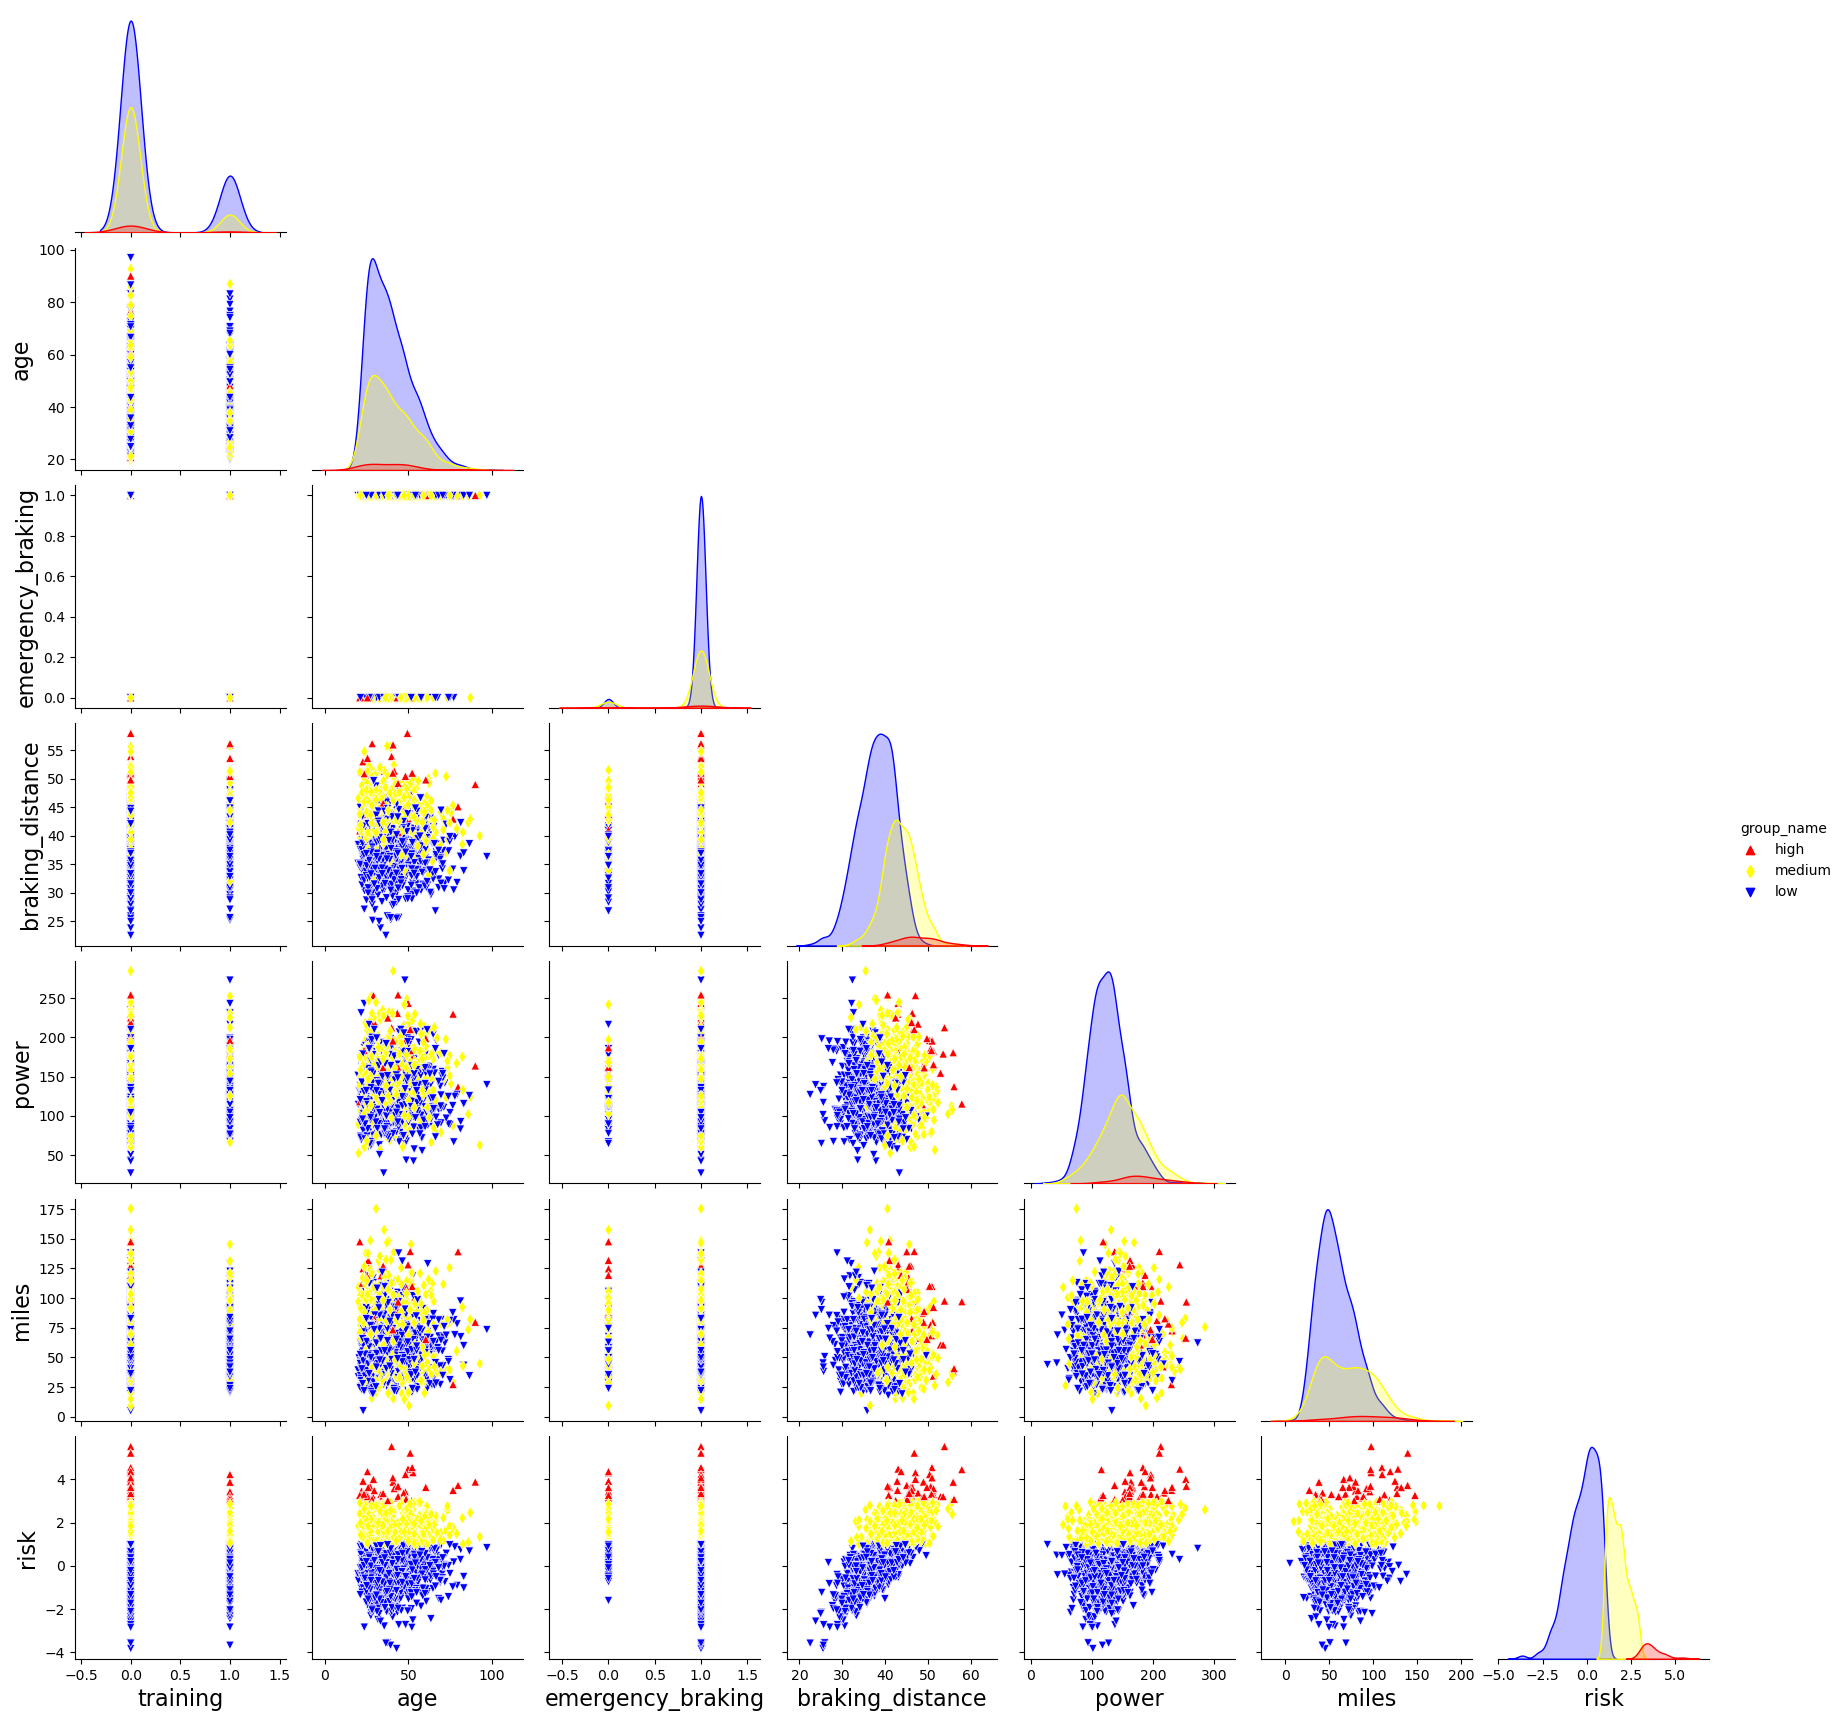

In [13]:
sns.pairplot(df, 
             kind="scatter", 
             diag_kind="kde",
             corner=True, 
             hue='group_name',
             hue_order = ['high', 'medium', 'low'],
             palette=colors, 
             markers=markers,
             vars=features);

In [14]:
plt.figure(figsize=(10, 10))

cm = df.corr()
cm3 = cm.iloc[:len(features), :len(features)]

hm = sns.heatmap(cm3,
                cbar=True,
                annot=True,
                square=True,
                cmap='RdBu',
                center=0,
                fmt='.2f',
                yticklabels=features,
                xticklabels=features)

ValueError: could not convert string to float: 'low'

<Figure size 1000x1000 with 0 Axes>

# Observations

* influence of age and training clearly down
* influence of braking distance clearly and power clearly up

# Step 2: Analyze for drift of input data

* https://docs.evidentlyai.com/reports/data-drift
* copied from
  * https://docs.evidentlyai.com/examples
  * https://github.com/evidentlyai/evidently/blob/main/examples/sample_notebooks/multiclass_target_and_data_drift_iris.ipynb

In [17]:
df_reference = pd.read_csv('https://github.com/DJCordhose/mlops-drift/raw/main/datasets/insurance_prediction/reference.csv.gz', delimiter=';')
# df_reference = pd.read_csv(f'../data/reference.csv', delimiter=';')

In [18]:
df_X = df.drop(['risk', 'group', 'group_name'], axis='columns')
df_reference_X = df_reference.drop(['risk', 'group', 'group_name'], axis='columns')

In [21]:
# from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataDriftTab, CatTargetDriftTab
data_drift_dashboard = Dashboard(tabs=[DataDriftTab(verbose_level=1)])

ModuleNotFoundError: No module named 'evidently.dashboard'

In [19]:
df_reference_X.columns

Index(['training', 'age', 'emergency_braking', 'braking_distance', 'power',
       'miles'],
      dtype='object')

In [22]:
# https://docs.evidentlyai.com/features/dashboards/column_mapping#column-mapping
from evidently.pipeline.column_mapping import ColumnMapping

column_mapping = ColumnMapping()
column_mapping.numerical_features = ['age', 'braking_distance', 'power', 'miles']
column_mapping.categorical_features = ['training', 'emergency_braking'] 

In [23]:
data_drift_dashboard.calculate(df_reference_X, df_X, column_mapping)
data_drift_dashboard.show(mode="inline")

NameError: name 'data_drift_dashboard' is not defined

# Step 3: Using predictions of model (we have no ground truth)

In [24]:
# Colab
# !wget https://github.com/openknowledge/mlops-data2day/raw/main/model/classifier.h5

In [25]:
model_path = 'classifier'
model = tf.keras.models.load_model(f'{model_path}.h5')

In [26]:
X = df_X
y_pred = model.predict(X, verbose=0).argmax(axis=1)
df_prediction = X.copy()
df_prediction['pred'] = y_pred

In [27]:
X = df_reference_X
y_pred = model.predict(X, verbose=0).argmax(axis=1)
df_reference_prediction = X.copy()
df_reference_prediction['pred'] = y_pred

In [28]:
target_drift_dashboard = Dashboard(tabs=[CatTargetDriftTab(verbose_level=1)])

NameError: name 'Dashboard' is not defined

In [29]:
column_mapping.prediction = 'pred'

In [30]:
target_drift_dashboard.calculate(df_reference_prediction, df_prediction, column_mapping)
target_drift_dashboard.show(mode="inline")

NameError: name 'target_drift_dashboard' is not defined

# Observations

* less bad drivers
* more good drivers
* younger drivers significantly better
* worse braking distance makes worse drivers
* training of driver has far less impact
* most cars have improved safety devices
